# PHASE THREE PROJECT: Pump it Up - Data Mining the Water Table

## Project Overview

The **"Pump it Up: Data Mining the Water Table"** competition, hosted by DrivenData, aims to enhance access to clean water in Tanzania by predicting the operational status of water pumps. Participants are tasked with developing models to classify waterpoints into three categories:

- **Functional**: The waterpoint is operational and requires no repairs.
- **Functional Needs Repair**: The waterpoint is operational but needs maintenance.
- **Non-Functional**: The waterpoint is not operational.

Utilizing data from Taarifa and the Tanzanian Ministry of Water, I aim to create predictive models that can effectively determine the status of these waterpoints. Accurate predictions will aid in optimizing maintenance efforts, ensuring that communities across Tanzania have reliable access to potable water.

For more details and to participate, visit the [competition page](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table).


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

In [3]:
# Load datasets
features_df = pd.read_csv('Features.csv')
target_df = pd.read_csv('Target.csv')
test_df = pd.read_csv('Test_Data.csv')

# Merge features and target on 'id' to avoid misalignment
merged_df = pd.merge(features_df, target_df, on='id')
print(f"Merged Training Data Shape: {merged_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

# check the data
print("\nFeatures Sample:\n", features_df.head(10))
print("\nTest Sample:\n", test_df.head(10))
print("\nTarget Sample:\n", target_df.head(10))

Merged Training Data Shape: (59400, 41)
Test Data Shape: (14850, 40)

Features Sample:
       id  amount_tsh date_recorded               funder  gps_height  \
0  69572      6000.0    2011-03-14                Roman        1390   
1   8776         0.0    2013-03-06              Grumeti        1399   
2  34310        25.0    2013-02-25         Lottery Club         686   
3  67743         0.0    2013-01-28               Unicef         263   
4  19728         0.0    2011-07-13          Action In A           0   
5   9944        20.0    2011-03-13  Mkinga Distric Coun           0   
6  19816         0.0    2012-10-01                 Dwsp           0   
7  54551         0.0    2012-10-09                Rwssp           0   
8  53934         0.0    2012-11-03             Wateraid           0   
9  46144         0.0    2011-08-03          Isingiro Ho           0   

      installer  longitude   latitude              wpt_name  num_private  ...  \
0         Roman  34.938093  -9.856322            

In [3]:
# Check data info
merged_df.info()
print("\nMissing Values:\n", merged_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

I observed incorrect data types:
1. `date_recorded` - should be datetime, not object.
2. `public_meeting` - should be boolean, not object.
3. `permit` - should be boolean, not object.

Additionally, missing values in:
- `funder`, `installer`, `subvillage`, `scheme_management` (impute with mode).
- `scheme_name` (>48% missing, drop due to high missingness).

In [4]:
# Convert data types
for df in [merged_df, test_df]:
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['public_meeting'] = df['public_meeting'].fillna(True).astype(bool)  # Fill NaN with True
    df['permit'] = df['permit'].fillna(True).astype(bool)  # Fill NaN with True

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
cat_cols_to_impute = ['funder', 'installer', 'subvillage', 'scheme_management']
for col in cat_cols_to_impute:
    merged_df[col] = imputer.fit_transform(merged_df[[col]]).ravel()
    test_df[col] = imputer.transform(test_df[[col]]).ravel()

# Drop high-missingness column
merged_df.drop(columns=['scheme_name'], inplace=True)
test_df.drop(columns=['scheme_name'], inplace=True)

# Drop redundant columns based on duplicates
drop_cols = ['quantity_group', 'payment_type', 'source_type', 'waterpoint_type_group']
merged_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

# Cap outliers
for col in ['amount_tsh', 'population']:
    cap = merged_df[col].quantile(0.99)
    merged_df[col] = np.where(merged_df[col] > cap, cap, merged_df[col])
    test_df[col] = np.where(test_df[col] > cap, cap, test_df[col])

print("Data Types After Conversion:\n", merged_df[['date_recorded', 'public_meeting', 'permit']].dtypes)
print("\nMissing Values After Cleaning:\n", merged_df.isnull().sum())

Data Types After Conversion:
 date_recorded     datetime64[ns]
public_meeting              bool
permit                      bool
dtype: object

Missing Values After Cleaning:
 id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 2
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quality_group 

## Feature Engineering (Building on my approach)

In [5]:
# Feature Engineering
for df in [merged_df, test_df]:
    # Temporal features
    df['record_year'] = df['date_recorded'].dt.year
    median_year = df['construction_year'].replace(0, df['construction_year'].median()).median()
    df['pump_age'] = df['record_year'] - df['construction_year'].replace(0, median_year)
    df['pump_age_bin'] = pd.cut(df['pump_age'], bins=[-1, 5, 15, 30, 100], labels=[0, 1, 2, 3])
    df.drop(columns=['date_recorded'], inplace=True)

    # Spatial features
    df['zero_gps'] = (df['gps_height'] == 0).astype(int)
    df['longitude'] = df['longitude'].replace(0, df['longitude'].median())
    df['latitude'] = df['latitude'].replace(-2e-8, df['latitude'].median())

    # Operational features
    df['water_per_person'] = df['amount_tsh'] / (df['population'].replace(0, 1))

# Verify new features
print("\nNew Features Sample:\n", merged_df[['record_year', 'pump_age', 'pump_age_bin', 'zero_gps', 'water_per_person']].head())


New Features Sample:
    record_year  pump_age pump_age_bin  zero_gps  water_per_person
0         2011        12            1         0          45.87156
1         2013         3            0         0           0.00000
2         2013         4            0         0           0.10000
3         2013        27            2         0           0.00000
4         2011        25            2         1           0.00000


## Preprocessing

In [8]:
# Separate features and target
X = merged_df.drop(columns=['id', 'status_group'])
y = merged_df['status_group']
X_test = test_df.drop(columns=['id'])

# Encode categorical variables with vectorized mapping
cat_cols = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # Fit and transform training data
    X[col] = le.fit_transform(X[col])
    
    # Convert X_test column to object type to avoid categorical issues
    X_test[col] = X_test[col].astype(str)
    
    # Create a boolean mask for values that exist in the encoder's classes
    mask = X_test[col].isin(le.classes_)
    
    # Transform valid values
    X_test.loc[mask, col] = le.transform(X_test.loc[mask, col])
    
    # Assign -1 for unseen values
    X_test.loc[~mask, col] = -1
    label_encoders[col] = le

# Encode target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Scale numerical features
scaler = StandardScaler()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Balance classes with SMOTE
n_functional = sum(y_train == 0)  # reference count for the "functional" class
smote = SMOTE(
    sampling_strategy={
        1: int(0.25 * n_functional),
        2: int(0.75 * n_functional)
    },
    random_state=42
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nBalanced Training Set Shape:", X_train_balanced.shape)

  File "c:\Users\hp\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\hp\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\hp\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\hp\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



Balanced Training Set Shape: (51613, 38)


## Model Training (Random Forest with Enhancements)

In [9]:
# Define Random Forest with class weights
class_weights = {0: 1, 1: 1.5, 2: 1.2}  # Adjusted for balance
rf = RandomForestClassifier(random_state=42, class_weight=class_weights)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=1, verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.8111716193945819


## Model Evaluation


Accuracy Score: 0.8114478114478114

Classification Report:
                          precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6452
functional needs repair       0.58      0.35      0.44       863
         non functional       0.84      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.68      0.70     11880
           weighted avg       0.81      0.81      0.81     11880



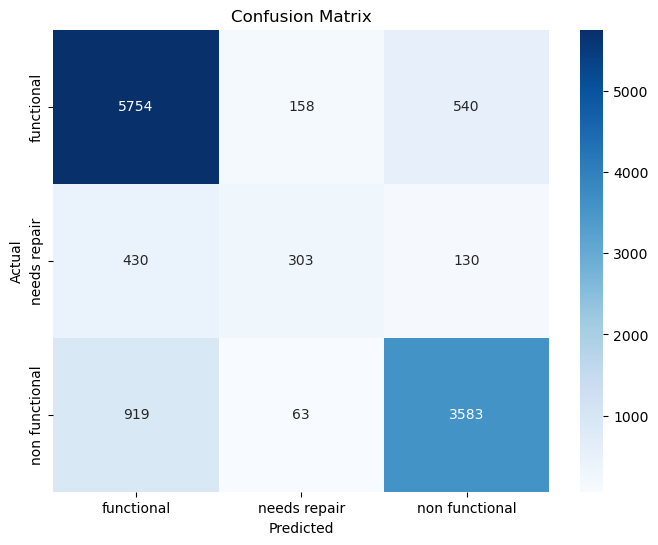

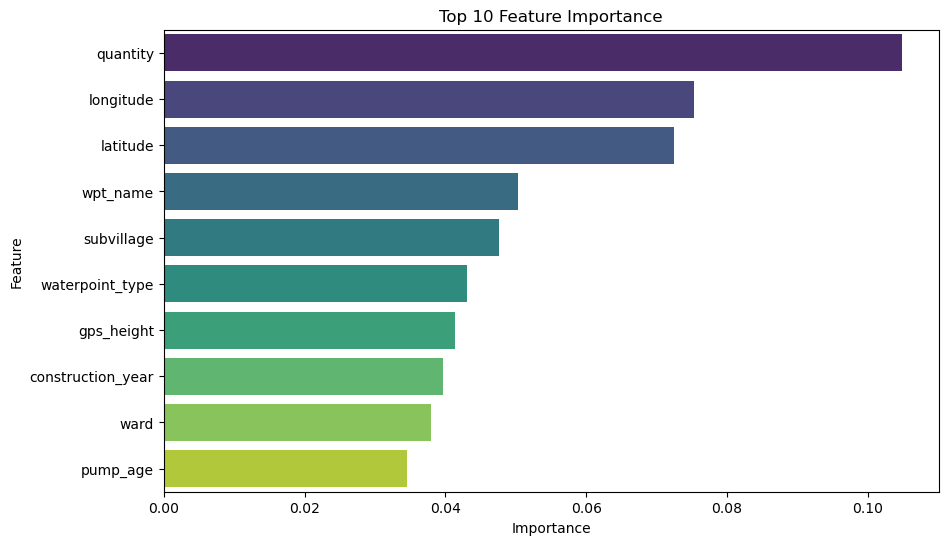

In [10]:
# Evaluate on validation set
y_pred = best_rf.predict(X_val)
print("\nAccuracy Score:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=['functional', 'functional needs repair', 'non functional']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['functional', 'needs repair', 'non functional'],
            yticklabels=['functional', 'needs repair', 'non functional'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Feature Importance')
plt.show()

## Predictions & Submission

In [11]:
# Test predictions
test_predictions = best_rf.predict(X_test)
test_predictions = le_y.inverse_transform(test_predictions)
submission = pd.DataFrame({'id': test_df['id'], 'status_group': test_predictions})
submission.to_csv('submission11.csv', index=False)
print("\nSample Submission:\n", submission.head())


Sample Submission:
       id    status_group
0  50785      functional
1  51630      functional
2  17168      functional
3  45559  non functional
4  49871      functional
